<a href="https://colab.research.google.com/github/bob123kk/NLP-Question-Answering/blob/master/Kaggle_Q%26A_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-Levenshtein
!pip install contractions
!pip install fuzzywuzzy

     |████████████████████████████████| 50 kB 3.5 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=a45e6c372fecd0df36898b1bac90018fc635db11bf7745099a1e0b38e9340cc8
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
     |████████████████████████████████| 283 kB 8.8 MB/s 
     |████████████████████████████████| 321 kB 48.0 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85452 sha256=428b810d1bc4624fb082428834f635683a87b530baf5c000c6c4d590b1e6ebef
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import os
import gc
import json
import numpy as np 
import pandas as pd
import pickle
import re
import Levenshtein
import unicodedata
import lightgbm as lgb
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from scipy import spatial
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler       
from sklearn.metrics import accuracy_score,recall_score, f1_score,confusion_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import numpy

In [ ]:
print(numpy.__version__)

1.19.5


### helper Function

In [ ]:
def read_data(path, size):
    df = []
    with open(path, 'rt') as reader:
      for i in range(size):
        df.append(json.loads(reader.readline()))
        df_train = pd.DataFrame(df)

    return df_train

In [ ]:
train_data_path='/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/simplified-nq-train.jsonl'

In [ ]:
read_train = read_data(train_data_path,100)
read_train.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid=  train_test_split(read_train, test_size=0.33, random_state=42)

In [ ]:
print('df_train shape: ', df_train.shape)
print('df_valid shape: ', df_valid.shape)

df_train shape:  (67, 6)
df_valid shape:  (33, 6)


In [ ]:

def unstack_datafram(df_train=df_train):
    ids = []
    doc = []
    targets = []
    questions = []
    Q_tfidf = []
    candidate_string = []
    C_tfidf = []
    features = []

    for index, row in df_train.iterrows():
    
        # process document text
        doc_text = row['document_text']
        tfidf = TfidfVectorizer()#stop_words=text.ENGLISH_STOP_WORDS)
        tfidf.fit([doc_text])
        
        question_tfidf = tfidf.transform([row['question_text']]).todense()

        start_token_true = row['annotations'][0]['long_answer']['start_token']
        end_token_true = row['annotations'][0]['long_answer']['end_token']

        # Tokenized doc text
        doc_tokenized = row['document_text'].split(' ')
        
        candidates = row['long_answer_candidates']
        # remove nested candidates
        candidates = [c for c in candidates if c['top_level'] == True]

        if start_token_true != -1:
            for c in candidates:
              ids.append(str(row['example_id']))
              doc.append([doc_text])
              
              questions.append(row['question_text'])
              Q_tfidf.append(question_tfidf)
              start_token = c['start_token']
              end_token = c['end_token']
              candidate = ' '.join(doc_tokenized[start_token:end_token])
              candidate_string.append(candidate)
              candidate_tfidf = tfidf.transform([candidate]).todense()
              C_tfidf.append(candidate_tfidf)

              #extract_features

              token_sort_ratio = fuzz.token_sort_ratio(str(row['question_text']), str(candidate))
              token_set_ratio = fuzz.token_set_ratio(str(row['question_text']), str(candidate))

              cos_d = spatial.distance.cosine(question_tfidf, candidate_tfidf)
              euc_d = np.linalg.norm(question_tfidf - candidate_tfidf)
              lev_d = Levenshtein.distance(row['question_text'], candidate)
              lev_r = Levenshtein.ratio(row['question_text'], candidate)
              jar_s = Levenshtein.jaro(row['question_text'], candidate)
              jaw_s = Levenshtein.jaro_winkler(row['question_text'], candidate)
              tfidf_score = np.sum(question_tfidf*candidate_tfidf.T)
              question_tfidf_sum = np.sum(question_tfidf)
              answer_tfidf_sum = np.sum(candidate_tfidf)

              features.append([
              token_sort_ratio,
              token_set_ratio,
              cos_d,
              euc_d,
              lev_d,
              lev_r,
              jar_s,
              jaw_s,
              tfidf_score,  
              question_tfidf_sum,
              answer_tfidf_sum,         
              ])

              if start_token == start_token_true and end_token == end_token_true:
                target = 1
              else:
                target = 0

              targets.append(target)


    train = pd.DataFrame()
    train['example_id'] = ids
    train['document'] = doc
    train['question'] = questions
    train['Q_tfidf'] = Q_tfidf
    train['candidate'] = candidate_string
    train['C_tfidf'] = C_tfidf
    train['target'] = targets

    features = np.array(features)
    features_df = pd.DataFrame(features)
    features_df.columns = ['token_sort_ratio',
                          'token_set_ratio', 
                          'cos_d','euc_d',
                          'lev_d','lev_r',
                          'jar_s','jaw_s',
                          'tfidf_score', 
                          'question_tfidf_sum',
                          'answer_tfidf_sum'  ]
    train = pd.concat([train, features_df], axis=1)

    return train



In [ ]:
valid = unstack_datafram(df_valid)
train = unstack_datafram(df_train)

In [ ]:
train.head(1)

,example_id,document,question,Q_tfidf,candidate,C_tfidf,target,token_sort_ratio,token_set_ratio,cos_d,euc_d,lev_d,lev_r,jar_s,jaw_s,tfidf_score,question_tfidf_sum,answer_tfidf_sum
0,-6638952910263008958,[Life or Something Like it - wikipedia <H1> Li...,where was life or something like it filmed,[[[[[0. 0. 0. 0. ...,"<Table> <Tr> <Th_colspan=""2""> Life or Somethin...",[[[[[0. 0. 0. 0. ...,0,9.0,75.0,0.966639,1.390424,1094.0,0.063086,0.432588,0.432588,0.033361,2.645751,3.230474


### Feature Engineering

In [ ]:
# Tokenizing & Cleaning  Q-A pairs 

from gensim.parsing.preprocessing import preprocess_string,strip_punctuation, \
remove_stopwords,strip_numeric,strip_punctuation

def get_tokenized(data='train'):
  if data =='train':
    X = train
  else:
    X = valid
  
  series = pd.Series(pd.concat([X['question'],X['candidate']]), dtype=str) 
  series.dropna()
  for row in series:
    
    yield row.split(' ')

In [ ]:
token_train = [x for x in get_tokenized('train')]
# token_test = [x for x in get_tokenized('test')]
token_train[0]

['where', 'was', 'life', 'or', 'something', 'like', 'it', 'filmed']

### Word Embedding

In [ ]:
from gensim.models import Word2Vec

# building a word2vec neural network on training set
model_w2v = Word2Vec(token_train,size = 300)
Word_model_path = '/content/drive/My Drive/Word2vec/GoogleNews.bin'
model_w2v.intersect_word2vec_format(Word_model_path,
                                    lockf=1.0,
                                    binary=True)
# training a word2vec neural network
model_w2v.train(token_train, total_examples=model_w2v.corpus_count, epochs=10)

(931803, 1622740)

In [ ]:
def get_token_has_vectors(model,data):
  for row in get_tokenized(data):
    tf_idf_tokens = []  
    for token in row:
      try:
        vector = model.wv[token]
        
        tf_idf_tokens.append(token)
      except:
        continue

    yield np.array(tf_idf_tokens)

In [ ]:
token_valid_vec = [x for x in get_token_has_vectors(model_w2v,'train')]
token_valid_vec[0]

array(['where', 'was', 'life', 'or', 'something', 'like', 'it', 'filmed'],
      dtype='<U9')

In [ ]:
print('number of Q-A pairs: ',len(token_valid_vec)/2 )

number of Q-A pairs:  1156.0


In [ ]:
# For valid tokens, find tfidf weights

from sklearn.feature_extraction.text import TfidfVectorizer
pass_through = lambda x:x
tfidf_QA = TfidfVectorizer(analyzer=pass_through)
# caculating TF_IDF weights for tokens having valid w2v vectors
X_trfmd = tfidf_QA.fit_transform(token_valid_vec)
# split into Questions and Answers weights
Q_trfmd = X_trfmd[:len(train)]
A_trfmd = X_trfmd[len(train):]

In [ ]:
token_valid_vec = [x for x in get_token_has_vectors(model_w2v,'train')]


In [ ]:
def get_tfidf_weights_and_wv(tfidf_matrix,tfidf_vec,model_w2v):
  w2v = []
  tfidf_weights = []
  row_records = tfidf_matrix.shape[0]
  vocab_dict = {id:word for word, id in tfidf_vec.vocabulary_.items()}
  # ct=0
  for row in range(row_records):

    word_id = tfidf_matrix[row,:].nonzero()[1]

    tfidf_weights.append([tfidf_matrix[row,id] for id in word_id])
    
    w2v.append([model_w2v.wv[vocab_dict[id]] for id in word_id])

  return np.array(tfidf_weights),np.array(w2v)

In [ ]:
Q_tfidf_weights,Q_w2v = get_tfidf_weights_and_wv(Q_trfmd,tfidf_QA,model_w2v)
A_tfidf_weights,A_w2v = get_tfidf_weights_and_wv(A_trfmd,tfidf_QA,model_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
from sklearn.metrics import pairwise_distances
def compute(wv_Q,wv_A,weight_Q,weight_A,method):
  temp = []
  c = 1
  for row in zip(wv_Q,wv_A,weight_Q,weight_A):

    if row:
      Q_v,A_v,Q_w,A_w = row
      
      Q_w =np.array(Q_w).reshape(-1,1)
      A_w =np.array(A_w).reshape(-1,1)

      dist = pairwise_distances(Q_v,A_v,metric=method)
      weights = np.matmul(Q_w,A_w.T)
      
      weighted_avg = np.average(dist,weights=weights)
      temp.append(weighted_avg)
      # print('{} :'.format(c),weighted_avg)
    else:
      temp.append(np.nan)
    c+=1
  return temp

In [ ]:
Q = Q_w2v
A = A_w2v
Q_w = Q_tfidf_weights
A_w = A_tfidf_weights
methods = ['euclidean','cosine','chebyshev','correlation']

def get_distance_features(Q,A,Q_w,A_w):
  features = []
  for method in methods:
    feature = compute(Q,A,Q_w,A_w,method)
    
    features.append(feature)
  
  features = np.array(features).T 
  features_df = pd.DataFrame(features)
  features_df.columns = methods


  return features_df

In [ ]:
features_df = get_distance_features(Q,A,Q_w,A_w)
train = pd.concat([train, features_df], axis=1)

In [ ]:
train[:3]

,example_id,document,question,Q_tfidf,candidate,C_tfidf,target,token_sort_ratio,token_set_ratio,cos_d,euc_d,lev_d,lev_r,jar_s,jaw_s,tfidf_score,question_tfidf_sum,answer_tfidf_sum,euclidean,cosine,chebyshev,correlation
0,-6638952910263008958,[Life or Something Like it - wikipedia <H1> Li...,where was life or something like it filmed,[[[[[0. 0. 0. 0. ...,"<Table> <Tr> <Th_colspan=""2""> Life or Somethin...",[[[[[0. 0. 0. 0. ...,0,9.0,75.0,0.966639,1.390424,1094.0,0.063086,0.432588,0.432588,0.033361,2.645751,3.230474,11.816193,0.983654,2.066756,0.983616
1,-6638952910263008958,[Life or Something Like it - wikipedia <H1> Li...,where was life or something like it filmed,[[[[[0. 0. 0. 0. ...,<P> Life or Something Like It is a 2002 romant...,[[[[[0. 0. 0. 0. ...,0,20.0,82.0,0.686455,1.171713,352.0,0.163170,0.441713,0.441713,0.313545,2.645751,6.532796,8.208655,0.774301,1.438670,0.773688
2,-6638952910263008958,[Life or Something Like it - wikipedia <H1> Li...,where was life or something like it filmed,[[[[[0. 0. 0. 0. ...,"<P> Lanie Kerrigan ( Angelina Jolie ) , a succ...",[[[[[0. 0.06189845 0. 0. ...,0,9.0,29.0,0.883023,1.328927,821.0,0.090708,0.434603,0.434603,0.116977,2.645751,8.480087,7.601752,0.739477,1.347625,0.738863


### Training Model

In [ ]:
cols_to_drop = ['example_id','document', 'Q_tfidf','C_tfidf','question', 'target','candidate' ]
feature_train = train.drop(cols_to_drop, axis=1, errors='ignore')
y_train = train['target'].values
n_features = feature_train.shape[1]

# set model config and Kfold
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations ': 200,
    'max_depth': 7,
    'num_leaves': 80,
    'learning_rate': 0.01, 
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'xgboost_dart_mode': True,
    'verbose': -1, 
    'is_unbalance': False,
    'num_threads': 5
}

feature_names = list(feature_train.columns) 

lgb_train = lgb.Dataset(
    feature_train, 
    y_train, 
    feature_name=feature_names,
    )
# lgb_train.raw_data = None


model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1500
)


In [ ]:
feature_valid.head(2)

,token_sort_ratio,token_set_ratio,cos_d,euc_d,lev_d,lev_r,jar_s,jaw_s,tfidf_score,question_tfidf_sum,answer_tfidf_sum
0,4.0,43.0,0.986270,1.404471,2650.0,0.027166,0.397897,0.397897,0.013730,2.828427,2.009709
1,12.0,60.0,0.685515,1.170910,613.0,0.107715,0.411379,0.411379,0.314485,2.828427,7.412493


### Evaluation

In [ ]:
# 1/pred_df.groupby(level='example_id')['candidate'].count().mean()

pred_df.groupby(level='example_id')['candidate'].count().mean()

31.210526315789473

Baseline f1 score  0.03204047217537943


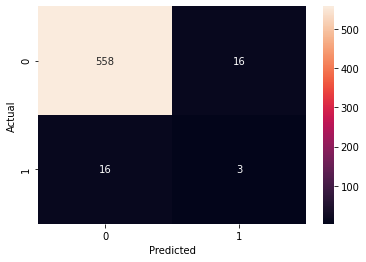

Model f1_score: [0.97212544 0.15789474]


In [ ]:
cols_to_drop = ['example_id','document', 'Q_tfidf','C_tfidf','target','question','candidate' ]
feature_valid = valid.drop(cols_to_drop, axis=1, errors='ignore')
y_valid = valid['target'].values
n_features = feature_valid.shape[1]

# model predict
p = model.predict(feature_valid,num_iteration=model.best_iteration)
valid['pred'] = p

max_pred = valid.groupby(['example_id'])['pred'].transform('max')
valid['pred_target'] = np.where(valid['pred'].eq(max_pred), 1,0)

pred_df = valid.groupby('example_id').apply(lambda x: x.sort_values(['pred_target'],ascending=False))
pred_df = pred_df[['example_id','target','question','pred_target','pred','candidate']]

print('Baseline f1 score ',1/pred_df.groupby(level='example_id')['candidate'].count().mean())

prediction = pred_df.pred_target.values
actual = pred_df.target.values
f1_scor = f1_score(actual, prediction,average=None)
# recall_scor = recall_score(actual, prediction,average=None)

data = {'y_Actual':actual,'y_Predicted': prediction }
df_result = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_result['y_Actual'], df_result['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,fmt="d")

plt.show()

print('Model f1_score: {}'.format(f1_scor))

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
pred_df=pred_df.drop('example_id', axis=1, errors='ignore').reset_index()
pred_df[['question',	'pred_target',	'pred',	'candidate']]

,question,pred_target,pred,candidate
0,who is the prime minister of republic of mauritius,1,0.609243,"<P> The current Prime Minister of Mauritius , Pravind Jugnauth , leader of the MSM , was appoint..."
1,who is the prime minister of republic of mauritius,0,0.025688,"<Table> <Tr> <Th_colspan=""2""> Prime Minister of Mauritius </Th> </Tr> <Tr> <Td_colspan=""2""> Coat..."
2,who is the prime minister of republic of mauritius,0,0.021371,"<P> After the country became a Republic on 12 March 1992 , the President became the Head of Stat..."
3,who is the prime minister of republic of mauritius,0,0.000715,"<P> According to the third Schedule of the Constitution of Mauritius , an oath under this sectio..."
4,who is the prime minister of republic of mauritius,0,0.064634,"<P> On 12 March 1992 , Mauritius became a Republic State , with a new constitution in 1992 , the..."
...,...,...,...,...
588,when were the plus and minus signs first recorded,0,0.000592,"<P> In mathematics and most programming languages , the rules for the order of operations mean t..."
589,when were the plus and minus signs first recorded,0,0.000013,<P> Some elementary teachers use raised plus and minus signs before numbers to show they are pos...
590,when were the plus and minus signs first recorded,0,0.000015,"<Dl> <Dd> 3 − 5 becomes 3 + 5 = 8 , </Dd> </Dl>"
591,when were the plus and minus signs first recorded,0,0.000015,<P> or even as </P>
